In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
stations = session.query(Station)

In [11]:
from sqlalchemy import create_engine, inspect, func

In [12]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


##  Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Calculate the date 1 year ago from today
# -- Comment: cannot operate with "today" date because the source data set contains information up to September, 2017. 
# -- That's why, the latest date from presented data set is used instead of "today".
# 1. reterieve greatest date from the source table
strLast_date = engine.execute('SELECT max(date) FROM Measurement').fetchall()
strLast_date = strLast_date[0][0]
print (strLast_date)

2017-08-23


In [16]:
def addMonths(initDate, months_number): 
    # The function subtracts months_number of months from initDate parameter 
    # initDate format: yyyy-mm-dd
    # months_number - integer
    import datetime as dt
    from dateutil.relativedelta import relativedelta
    init_date = dt.datetime.strptime(initDate,'%Y-%m-%d')
    return_date = init_date +  relativedelta(months=months_number)
    return_date = '{0}-{1:02d}-{2:02d}'.format(return_date.year,return_date.month, return_date.day)
    return return_date

In [17]:
# get 12 months date interval
first_day = addMonths(strLast_date,-12)
print("Interval from {0} to {1}".format(first_day,strLast_date))

Interval from 2016-08-23 to 2017-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
strSQL = "SELECT date, prcp FROM Measurement where date between '" + first_day + "' and '" + strLast_date + "'";
measureData = engine.execute(strSQL).fetchall()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(measureData, columns=['Date','Precipitation'])
df = df.set_index('Date') 

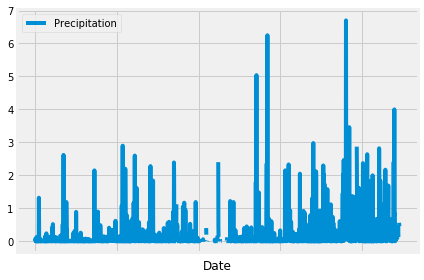

In [20]:
# # Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# ---previously selected 12 months interval
start_date = first_day
end_date = strLast_date
# Select data
sel = [Measurement.station ,Measurement.date ,Measurement.prcp ,Measurement.tobs,\
      Station.id, Station.name ,Station.latitude ,Station.longitude ,Station.elevation]
res = session.query(*sel).filter(Station.station == Measurement.station).\
  filter(Measurement.date >= start_date).\
  filter(Measurement.date <= end_date).all()
df_all = pd.DataFrame(res, columns = ['station' ,'date','prcp' ,'tobs', 'station_id','name' ,'latitude' ,'longitude' ,'elevation'])
df_all.head(5)

,station,date,prcp,tobs,station_id,name,latitude,longitude,elevation
0,USC00519397,2016-08-23,0.00,81.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2016-08-24,0.08,79.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2016-08-25,0.08,80.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2016-08-26,0.00,79.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2016-08-27,0.00,77.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [23]:
# How many stations are available in this dataset?
number_of_stations = len(df_all["station_id"].unique())
print ("Number of Stations = {}".format(number_of_stations))

Number of Stations = 7


In [24]:
# What are the most active stations?
# List the stations and the counts in descending order.
s = df_all["station"].value_counts().sort_values(ascending = False)
print("List the stations and the counts in descending order:")
df = pd.DataFrame({"Station":s.keys().tolist(),"Counts":s.tolist()})
df

List the stations and the counts in descending order:


,Station,Counts
0,USC00519397,361
1,USC00519281,352
2,USC00516128,349
3,USC00513117,343
4,USC00519523,337
5,USC00514830,305
6,USC00517948,183


In [25]:
#most_active_stationID = 
most_active_station  = df.loc[0 , "Station"]
most_active_stationID = df_all.loc[df_all["station"] == most_active_station, "station_id" ].max()
print("The most active station = {0}, station ID = {1}".format(most_active_station,most_active_stationID))

The most active station = USC00519397, station ID = 1


In [26]:
df_all = df_all.set_index("station")

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_temperature = df_all.loc[most_active_station, "tobs"].min()
max_temperature = df_all.loc[most_active_station, "tobs"].max()
avg_temperature = df_all.loc[most_active_station, "tobs"].mean()
print (" min temperatur={0}\n max temperature={1}\n averate temperature={2:.2f}".\
       format(min_temperature,max_temperature,avg_temperature))

 min temperatur=60.0
 max temperature=87.0
 averate temperature=75.21


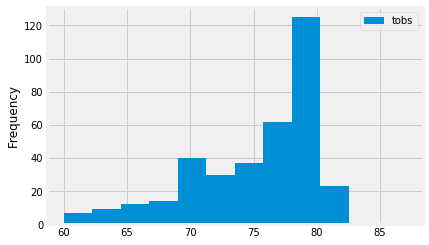

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_stationID = int(most_active_stationID)
sel = [Measurement.date, Measurement.tobs]
res = session.query(*sel).filter(Station.station == Measurement.station).\
  filter(Measurement.date >= start_date).\
  filter(Measurement.date <= end_date).filter(Station.id == most_active_stationID).all()

df_temperature = pd.DataFrame(res, columns = ['date','tobs'])
df_temperature.plot.hist(bins=12)
plt.show()

In [29]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
#print(calc_temps('2012-02-28', '2012-03-05'))

In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# 1.get date interval
tripp_start_date = '2017-10-28'
tripp_end_day = '2017-11-10'
first_day = addMonths(tripp_start_date,-12)
last_day = addMonths(tripp_end_day,-12)
print("Interval from {0} to {1}".format(first_day,last_day))

#2.call the function
res = calc_temps(first_day, last_day)
print(res)
tmin = res[0][0]
tavg = res[0][1]
tmax = res[0][2]

Interval from 2016-10-28 to 2016-11-10
[(63.0, 74.59550561797752, 79.0)]


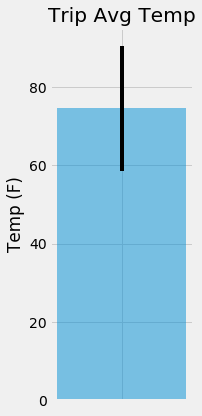

In [31]:
# Plot the results from your previous query as a bar chart.
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, figsize=(3, 6))
ax.bar("",tavg, yerr=(tmax-tmin), alpha=0.5)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.tight_layout()
plt.show() 

In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station , Station.name ,Station.latitude ,Station.longitude ,Station.elevation, func.avg(Measurement.prcp)]
res = session.query(*sel).filter(Station.station == Measurement.station).\
  filter(Measurement.date >= first_day).\
  filter(Measurement.date <= last_day).\
  group_by (Measurement.station ,Station.name ,Station.latitude ,Station.longitude ,Station.elevation).\
  order_by (func.avg(Measurement.prcp).desc()).all()
df_all_ = pd.DataFrame(res, columns = ['station', 'name', 'latitude' ,'longitude' ,'elevation','prcp'])
df_all_

,station,name,latitude,longitude,elevation,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.299286
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.060000
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.056429
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.031429
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.027143
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.024286
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.000000
